# Import Library

In [47]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import os

from copy import deepcopy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [48]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Labeling

In [49]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}

# Membuat method create_df

In [50]:
def create_df(base):
    data = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            data["images"] += [img]
            data["labels"] += [label_index[i]]
    return pd.DataFrame(data)

# Membuat dataset

In [51]:
train_df = create_df('./data/train')
test_df = create_df('./data/test')
valid_df = create_df('./data/valid')

In [52]:
train_df = pd.concat([train_df, valid_df, test_df])

# Mendefinisikan training parameters

In [53]:
EPOCHS = 16
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 32
OUT_CLASSES = 3
IMG_SIZE = 224

In [54]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))
        
        return img, label

In [55]:
# Data latih
train_transform = transforms.Compose([transforms.ToPILImage(),
                            transforms.ToTensor(),
                            transforms.Resize((IMG_SIZE, IMG_SIZE)),
                            transforms.RandomVerticalFlip(0.6),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])])

# Validasi
transform = transforms.Compose([transforms.ToPILImage(),
                        transforms.ToTensor(),
                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])])

In [56]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [57]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [58]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [59]:
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Training Tools

In [61]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# Training

In [62]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    
    diff = 0
    total = 0
    acc = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    
    diff = 0
    total = 0
    acc = 0
    
    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                
            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
            
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    scheduler.step()
    
    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

Epochs 1 train loss 0.04786459222666473 acc 0.4240380801269338 val loss 0.03524590692822895 acc 0.49206349206349204
Epochs 2 train loss 0.02601373008866482 acc 0.6207854026180087 val loss 0.030162693016112796 acc 0.5555555555555556
Epochs 3 train loss 0.018785048954451856 acc 0.7619992066640222 val loss 0.028882620826600088 acc 0.6222222222222222
Epochs 4 train loss 0.012562657001944394 acc 0.8476794922649742 val loss 0.029679778076353528 acc 0.6349206349206349
Epochs 5 train loss 0.008185781260678239 acc 0.9059896866322887 val loss 0.046363618638780385 acc 0.5968253968253968
Epochs 6 train loss 0.005720342449970966 acc 0.9373264577548592 val loss 0.03024055106299264 acc 0.6857142857142857
Epochs 7 train loss 0.004070932771131331 acc 0.9650932169773899 val loss 0.028651327178591774 acc 0.7492063492063492
Epochs 8 train loss 0.003645652563387631 acc 0.9627132090440301 val loss 0.027966817787715367 acc 0.7523809523809524
Epochs 9 train loss 0.002463990241327559 acc 0.9734232447441491 val

# Performance log

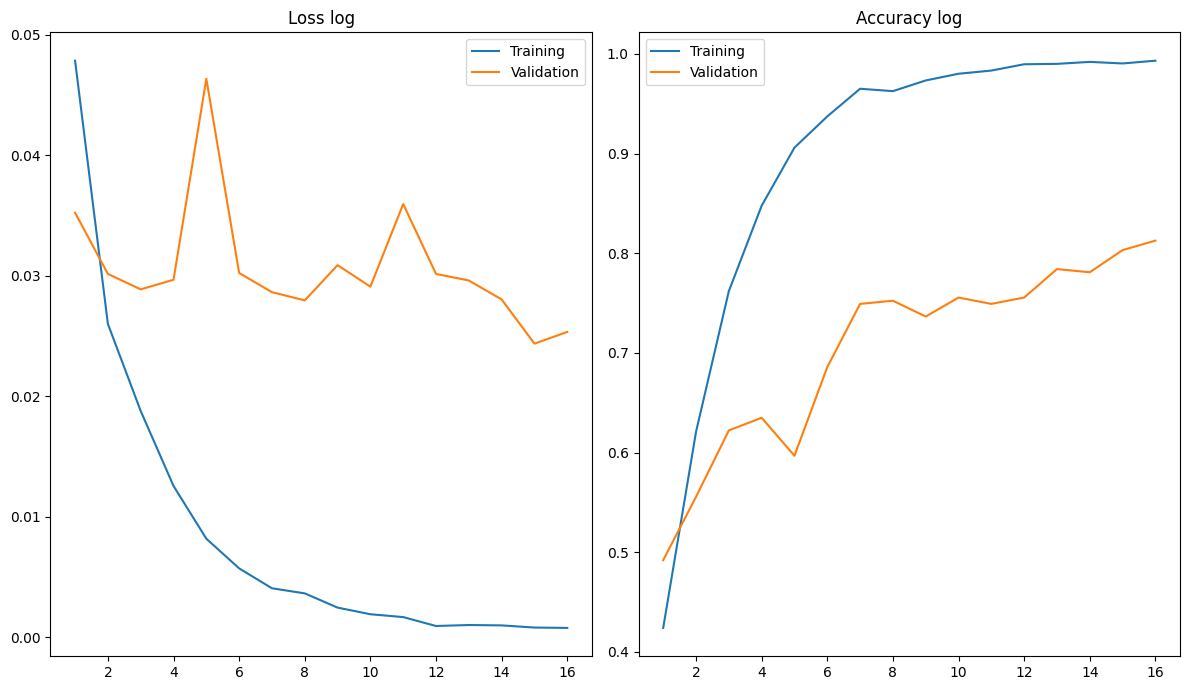

In [63]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [64]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        
        return out.argmax(1).item()

In [65]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

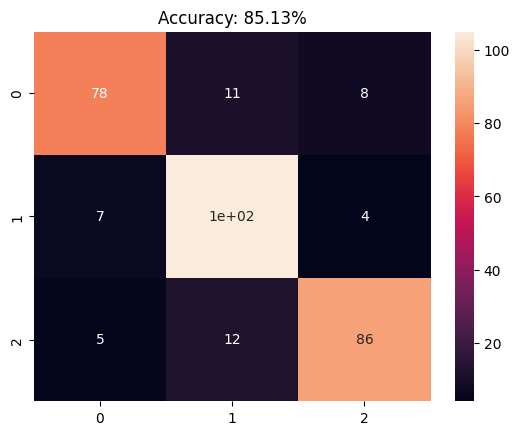

In [66]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [67]:
print(report)

              precision    recall  f1-score   support

           0       0.87      0.80      0.83        97
           1       0.82      0.91      0.86       116
           2       0.88      0.83      0.86       103

    accuracy                           0.85       316
   macro avg       0.85      0.85      0.85       316
weighted avg       0.85      0.85      0.85       316



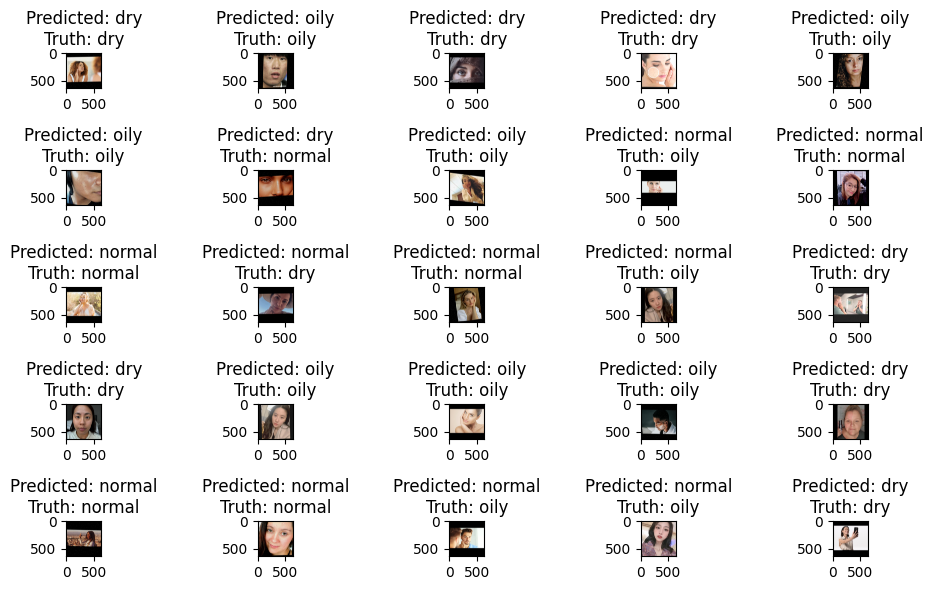

In [68]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1
        
plt.tight_layout()
plt.show()

In [69]:
torch.save(model.state_dict(), './model/model2.pth')